<a href="https://colab.research.google.com/github/quant-macro-book/Colab/blob/main/chapter4/2_how_to_interpolation_cheb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
!pip install japanize_matplotlib
import japanize_matplotlib # matplolibで日本語を表示させるためのモジュール。インストールしていない場合は、!pip install japanize_matplotlib でインストールする
from scipy.interpolate import interp1d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 13.7 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=c34b82e687494124acdbadf551ce6b21f56ebe8b108f4886da14c8426f09c2e7
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [2]:
def polybas(kmin,kmax,Np,kgrid):
    """
    ----------------------------------------
    === 基底関数の行列を再帰的に求める関数 ===
    ----------------------------------------
    <input>
    ・kmin: 状態変数のグリッドの最小値
    ・kmax: 状態変数のグリッドの最大値
    ・Np: 多項式の次数-1   
    ・kgrid: 状態変数のグリッド(Ng個)
    <output>
    ・T: 基底関数の行列(NgxNp)
    (Ng個の評価点でNp-1次のチェビシェフ多項式で近似する)
    """
    Ng = len(kgrid) #グリッドの数
    x = (2/(kmax-kmin)) * (kgrid-kmin) - 1 #グリッドを[-1,1]の範囲に変換

    #基底関数の行列(NgxNp)を再帰的に求める
    T = np.zeros((Ng,Np))
    T0 = np.ones(Ng)
    T1 = x
    T2 = 2*x*T1 - T0
    T[:,0] = T1
    T[:,1] = T2

    for i in range(2,Np-1):
        T[:,i] = 2*x*T[:,i-1] - T[:,i-1]
    
    T = np.hstack([T0.reshape((Ng,1)),T[:,0:Np-1]])
    #np.linspaceで返されるベクトル(T0)は(Ng,)と1次元である。
    #このベクトルを行列に結合させるためにベクトルT0を(Ng,1)の2次元配列に変換している。 

    return T

In [3]:
def polygrid(kmin,kmax,N):
    """
    -----------------------------------------------
    === チェビシェフ多項式における評価点を返す関数 ===
    -----------------------------------------------
    <input>
    ・kmin: 状態変数のグリッドの最小値
    ・kmax: 状態変数のグリッドの最大値
    ・N: 状態変数のグリッド数
    <output>
    ・k: 状態変数のグリッド
    """
    #チェビシェフ極値点
    temp = np.linspace(0,N-1,N)
    x = -np.cos((np.pi/(N-1))*temp)

    #チェビシェフゼロ点
    #x = -np.cos((np.pi/2/(N-1))*(2*temp-1))
    #x[0] = 0.0

    #x([-1,1])からk([kmin,kmax])に変換
    k = 0.5*(kmax-kmin)*(x+1) + kmin

    return k

In [4]:
def f(x0):
    """
    ------------------
    === ルンゲ関数 ===
    ------------------
    """
    nx = x0.size
    f0 = np.ones(nx) / (np.ones(nx)+25*x0**2)

    return f0

In [5]:
#データ点
xmin = -1
xmax = 1
nxd = 11
xd = np.linspace(xmin,xmax,nxd)
yd = f(xd)

#関数による値
nx = 1001
x0 = np.linspace(xmin,xmax,nx)
y0 = f(x0)

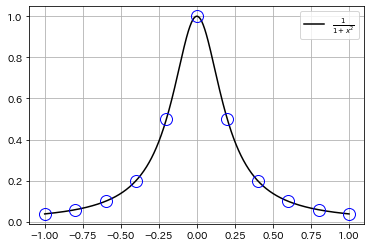

In [6]:
fig, ax = plt.subplots()
ax.plot(x0,y0,c="k",lw=1.5,label=r"$\frac{1}{1+x^{2}}$")
ax.plot(xd, yd, "o", mfc="none", mec="b",markersize=12,lw=2)
ax.legend(loc="upper right")
ax.grid()
plt.show()

In [7]:
#Python関数(scipy.interpolate.interp1d)を使った線形補間による近似
x1 = np.linspace(xmin,xmax,nx)
#(xd,yd)による線形補間した関数を定義する
#Matlab関数(interp1)は補間と評価を1つの関数で行うが、interp1d関数では補間と評価を別々に行う。
interp_y1 = interp1d(xd,yd,kind="linear",fill_value="extrapolate") 
y1 = interp_y1(x1)

In [8]:
#通常の多項式による近似
Xd = np.ones((nxd,nxd))
X2 = np.ones((nx,nxd))
x2 = x1
for i in range(nxd-1):
    Xd[:,i+1] = xd**(i+1)
    X2[:,i+1] = x2**(i+1)

b = (np.linalg.inv(Xd.T @ Xd)) @ (Xd.T @ yd)
y2 = X2 @ b

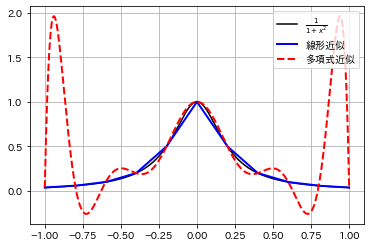

In [9]:
fig, ax = plt.subplots()
ax.plot(x0,y0,c="k",ls="-",lw=1.5,label=r"$\frac{1}{1+x^{2}}$")
ax.plot(x1,y1,c="b",ls="-",lw=2.0,label="線形近似")
ax.plot(x2,y2,c="r",ls="--",lw=2.0,label="多項式近似")
ax.legend(loc="upper right")
ax.grid()
plt.show()

In [10]:
#チェビシェフ多項式による近似
nxd=11
xcheb = polygrid(xmin,xmax,nxd)
ycheb = f(xcheb)
T = polybas(xmin,xmax,nxd,xcheb)

theta = np.linalg.inv(T) @ ycheb

x3 = x1
T3 = polybas(xmin,xmax,nxd,x3)
y3 = T3@theta 

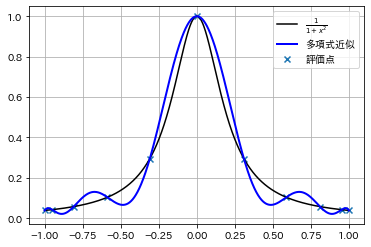

In [11]:
fig, ax = plt.subplots()
ax.plot(x0,y0,c="k",ls="-",lw=1.5,label=r"$\frac{1}{1+x^{2}}$")
ax.plot(x3,y3,c="b",ls="-",lw=2.0,label="多項式近似")
ax.scatter(xcheb,ycheb,marker="x",label="評価点")
ax.legend(loc="upper right")
ax.grid()
plt.show()

In [12]:
#チェビシェフ多項式による近似
nxd=21
xcheb = polygrid(xmin,xmax,nxd)
ycheb = f(xcheb)
T = polybas(xmin,xmax,nxd,xcheb)
theta = np.linalg.inv(T) @ ycheb

x3 = x1
T3 = polybas(xmin,xmax,nxd,x3)
y3 = T3 @ theta 

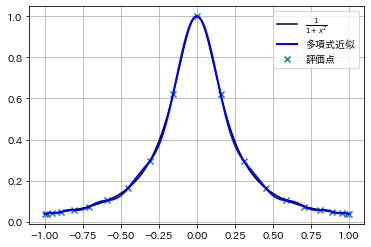

In [13]:
fig, ax = plt.subplots()
ax.plot(x0,y0,c="k",ls="-",lw=1.5,label=r"$\frac{1}{1+x^{2}}$")
ax.plot(x3,y3,c="b",ls="-",lw=2.0,label="多項式近似")
ax.scatter(xcheb,ycheb,marker="x",label="評価点")
ax.legend(loc="upper right")
ax.grid()
plt.show()